In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import os

import xgboost as xgb

from catboost import CatBoostClassifier

from xgboost import plot_importance

In [3]:
data=pd.read_csv('final_crimesNY.csv')

In [1]:
data.head()

NameError: name 'data' is not defined

In [10]:
filtered_df = data[~data['OFNS_DESC'].isin(['ADMINISTRATIVE', 'OTHER'])]
data=filtered_df
data.OFNS_DESC.unique()

array(['SEXUAL', 'PROPERTY', 'PERSONAL', 'DRUGS/ALCOHOL'], dtype=object)

In [11]:
# Create a dictionary to store the mapping
label_mapping = {}

# Original column values
original_values = data['OFNS_DESC'].unique()
label_encoder=LabelEncoder()
# Apply label encoding
data['target'] = label_encoder.fit_transform(data['OFNS_DESC'])

# New column values after label encoding
new_values = data['target'].unique()

# Populate the dictionary
label_mapping['original_to_encoded'] = dict(zip(original_values, new_values))
label_mapping['encoded_to_original'] = dict(zip(new_values, original_values))

# Print the dictionary
print(label_mapping)

{'original_to_encoded': {'SEXUAL': 3, 'PROPERTY': 2, 'PERSONAL': 1, 'DRUGS/ALCOHOL': 0}, 'encoded_to_original': {3: 'SEXUAL', 2: 'PROPERTY', 1: 'PERSONAL', 0: 'DRUGS/ALCOHOL'}}


In [12]:
min_count = data['target'].value_counts().min()

# Sample the same number of examples for each class
balanced_data = data.groupby('target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8804\1352695909.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [13]:
balanced_data.target.value_counts()

target
0    509370
1    509370
2    509370
3    509370
Name: count, dtype: int64

# Data preperation 

In [14]:
# Set the list of features to include in Machine Learning Model
feature_lst=['year', 'month', 'day', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'ADDR_PCT_CD',
       'BORO_NM','IN_PARK', 'IN_PUBLIC_HOUSING',
       'IN_STATION', 'VIC_AGE_GROUP', 'VIC_RACE','VIC_SEX','target']

df_crimes=data[feature_lst].copy()
df_crimes.info()
df_crimes.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6012896 entries, 0 to 6901167
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   year               int64  
 1   month              int64  
 2   day                int64  
 3   hour               int64  
 4   Latitude           float64
 5   Longitude          float64
 6   COMPLETED          object 
 7   ADDR_PCT_CD        float64
 8   BORO_NM            object 
 9   IN_PARK            int64  
 10  IN_PUBLIC_HOUSING  int64  
 11  IN_STATION         int64  
 12  VIC_AGE_GROUP      object 
 13  VIC_RACE           object 
 14  VIC_SEX            object 
 15  target             int32  
dtypes: float64(3), int32(1), int64(7), object(5)
memory usage: 756.9+ MB


,year,month,day,hour,Latitude,Longitude,COMPLETED,ADDR_PCT_CD,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,target
0,2015,5,28,15,40.84,-73.94,COMPLETED,46.0,BRONX,0,0,0,25-44,WHITE HISPANIC,F,3
1,2013,10,28,13,40.62,-74.06,COMPLETED,120.0,STATEN ISLAND,0,0,0,45-64,WHITE,M,2
2,2012,5,9,20,40.80,-74.00,COMPLETED,24.0,MANHATTAN,0,0,0,UNKNOWN,UNKNOWN,E,1
3,2014,1,3,13,40.75,-73.90,ATTEMPTED,108.0,QUEENS,0,0,0,45-64,ASIAN / PACIFIC ISLANDER,M,2
4,2016,4,13,0,40.80,-73.94,COMPLETED,40.0,BRONX,0,0,0,UNKNOWN,UNKNOWN,E,2


In [15]:
completed_mapping={'COMPLETED':1,'ATTEMPTED':0}
# Apply the mapping to the COMPLETED column
df_crimes['COMPLETED'] = df_crimes['COMPLETED'].map(completed_mapping)

In [16]:
df_crimes.head()

,year,month,day,hour,Latitude,Longitude,COMPLETED,ADDR_PCT_CD,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,target
0,2015,5,28,15,40.84,-73.94,1,46.0,BRONX,0,0,0,25-44,WHITE HISPANIC,F,3
1,2013,10,28,13,40.62,-74.06,1,120.0,STATEN ISLAND,0,0,0,45-64,WHITE,M,2
2,2012,5,9,20,40.80,-74.00,1,24.0,MANHATTAN,0,0,0,UNKNOWN,UNKNOWN,E,1
3,2014,1,3,13,40.75,-73.90,0,108.0,QUEENS,0,0,0,45-64,ASIAN / PACIFIC ISLANDER,M,2
4,2016,4,13,0,40.80,-73.94,1,40.0,BRONX,0,0,0,UNKNOWN,UNKNOWN,E,2


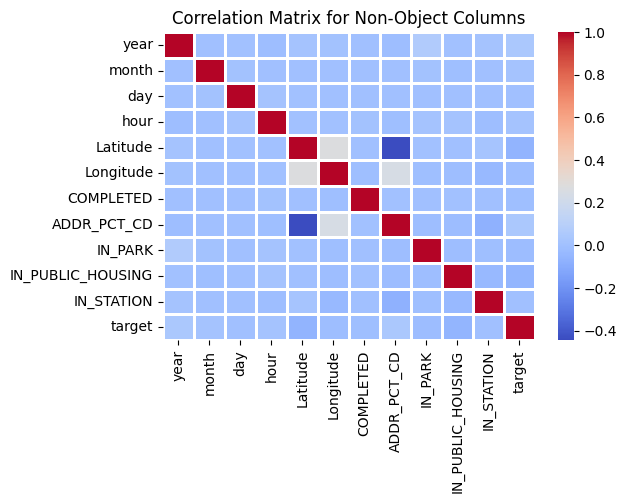

In [17]:
non_object_columns = df_crimes.select_dtypes(exclude='object')

# Calculate correlation matrix
corr = non_object_columns.corr()

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, cmap="coolwarm", linewidth=2, linecolor="white",annot=False)
plt.title("Correlation Matrix for Non-Object Columns")
plt.show()

In [18]:
df = pd.get_dummies(df_crimes)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6012896 entries, 0 to 6901167
Data columns (total 37 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   year                                     int64  
 1   month                                    int64  
 2   day                                      int64  
 3   hour                                     int64  
 4   Latitude                                 float64
 5   Longitude                                float64
 6   COMPLETED                                int64  
 7   ADDR_PCT_CD                              float64
 8   IN_PARK                                  int64  
 9   IN_PUBLIC_HOUSING                        int64  
 10  IN_STATION                               int64  
 11  target                                   int32  
 12  BORO_NM_BRONX                            bool   
 13  BORO_NM_BROOKLYN                         bool   
 14  BORO_NM_MANHATTAN      

In [19]:
bool_columns = df.select_dtypes(include='bool').columns

# Convert boolean columns to uint8
df[bool_columns] = df[bool_columns].astype('uint8')

In [20]:
bool_columns = df.select_dtypes(include='bool').columns

# Convert boolean columns to uint8
df[bool_columns] = df[bool_columns].astype('uint8')

In [23]:
class_names = ['PROPERTY', 'PERSONAL', 'SEXUAL', 'DRUGS/ALCOHOL']

def plot_cm(y_pred, y_test, algorithm, figure_name, class_names=None):
    mat_RF = confusion_matrix(y_pred, y_test)
    
    # Define a custom color map
    cmap = sns.color_palette("pastel", as_cmap=True)  # You can choose any seaborn color palette
    
    plt.figure(figsize=(16, 4))
    sns.heatmap(mat_RF, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names, cmap=cmap)
    
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.title(algorithm)
    plt.savefig(figure_name)

In [22]:

def save_model(model, model_name,is_tree=False):
    joblib.dump(model.estimators_[0] if is_tree else model,f'{model_name}.joblib')
    print(f"Model size: {np.round(os.path.getsize(f'{model_name}.joblib') / 1024 / 1024, 2) } MB")

# MODELING

In [24]:
# set X and y
y = df['target']
X = df.drop('target', axis=1)

In [25]:
y.head()

0    3
1    2
2    1
3    2
4    2
Name: target, dtype: int32

In [26]:
X.head()
# we need to rename this features because XGBOOST can't accept feature which their name contains one of this ('>','<','[',']')
X.rename(columns={'VIC_AGE_GROUP_<18': 'VIC_AGE_GROUP_-18'}, inplace=True)

Split the data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=40)

# FIRST MODEL XGBOOST

In [28]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 4,  # Assuming a classification task with 3 classes
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'tree_method' : "hist",
        'device' : "cuda",
        'verbosity': 1,
        'n_jobs': -1,  # Utilize all available CPU cores
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared=False)

In [31]:
bestparams = {
    'max_depth': 5,
    'learning_rate': 0.08,
    'n_estimators': 60,
    'subsample': 0.500,
    'colsample_bytree': 0.269,
    'min_child_weight': 7.47,
    'objective': 'multi:softmax',  # Already included in your code
    'num_class': 6,               # Already included in your code
    'tree_method': 'gpu_hist',    # Enable GPU acceleration
    'predictor': 'gpu_predictor'  # Use GPU for prediction
}

modelxgb = xgb.XGBClassifier(**bestparams)  
modelxgb.fit(X_train, y_train)
y_pred = modelxgb.predict(X_test)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [20:40:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFound

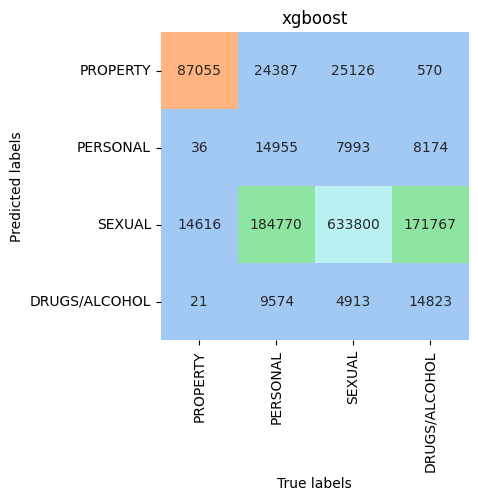

In [32]:
plot_cm(y_pred, y_test, 'xgboost', 'xgboost_confusion_matrix.jpg', class_names)

In [33]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.63      0.86      0.73    101728
           1       0.48      0.06      0.11    233686
           2       0.63      0.94      0.76    671832
           3       0.51      0.08      0.13    195334

    accuracy                           0.62   1202580
   macro avg       0.56      0.48      0.43   1202580
weighted avg       0.58      0.62      0.53   1202580



In [34]:
accuracy = accuracy_score(y_pred, y_test)
print('XGBBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

XGBBoost Model accuracy score: 0.6242


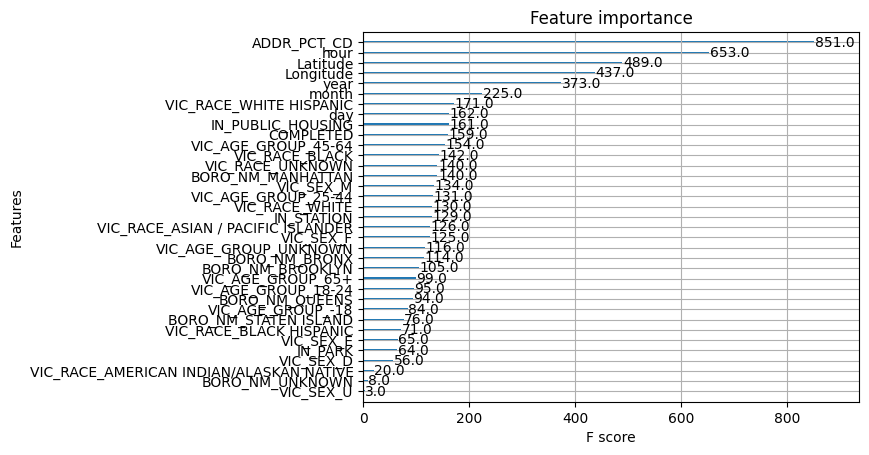

In [35]:
plot_importance(modelxgb)
plt.show()

In [36]:
save_model(modelxgb, "modelxgboost")

Model size: 0.56 MB
